In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'IMDb_top_rated_data.csv'
df = pd.read_csv(file_path)

In [3]:
print(df.head())  # View the first few rows of the dataset
print(df.info())  # Get an overview of the dataset's columns and data types
print(df.describe())  # Get summary statistics for numeric columns

           id                           title                         genres  \
0   tt5988370                            Reis               Biography, Drama   
1   tt7221896  Cumali Ceber: Allah Seni Alsin                         Comedy   
2  tt13423846                      321 Action                          Drama   
3  tt20255706                  The Pogmentary  Biography, Documentary, Sport   
4  tt21403988                The Last Pharaoh    Documentary, Drama, History   

   averageRating  numVotes  releaseYear  
0            1.0     74166         2017  
1            1.0     39466         2017  
2            1.0     10215         2020  
3            1.1     13805         2022  
4            1.1     12019         2023  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1000 non-null   object 
 1   title          1000 non-n

In [4]:
# Clean 'genres' by removing leading/trailing spaces and commas
df['genres'] = df['genres'].str.strip().str.rstrip(',')

In [5]:
# Split genres into multiple rows and strip extra whitespace
df_genres = df.assign(genres=df['genres'].str.split(',')).explode('genres')
df_genres['genres'] = df_genres['genres'].str.strip()  # Remove extra whitespace

In [6]:
# Standardize column names (e.g., lowercase and replace spaces with underscores)
df_genres.columns = df_genres.columns.str.lower().str.replace(' ', '_')

In [7]:
print(df_genres.columns.tolist())

['id', 'title', 'genres', 'averagerating', 'numvotes', 'releaseyear']


In [8]:
# Convert releaseYear to datetime
df_genres['releaseyear'] = pd.to_datetime(df_genres['releaseyear'], format='%Y')

In [9]:
# Add decade column based on releaseYear
df_genres['decade'] = (df_genres['releaseyear'].dt.year // 10) * 10

In [10]:
df_genres['releaseyear'] = df_genres['releaseyear'].dt.year

In [11]:
import os

# Create a folder to save images if it doesn't exist
output_folder = "visuals_DB"
os.makedirs(output_folder, exist_ok=True)

sns.set(style="whitegrid")

In [12]:
import psycopg2

In [13]:
# Define connection parameters
conn = psycopg2.connect(
    dbname="imdb_project",
    user="postgres",
    password="root123",
    host="localhost",
    port="5432"
)
cur = conn.cursor()

In [16]:
# # Step 4: Create the table if it doesn't exist

# cur.execute("""
# CREATE TABLE IF NOT EXISTS movies (
#     id TEXT,
#     title TEXT,
#     genres TEXT,
#     averagerating FLOAT,
#     numvotes INTEGER,
#     releaseyear INTEGER,
#     decade INTEGER,
#     PRIMARY KEY (id, genres)  -- allows multiple genres per movie
# )
# """)
# conn.commit()

insert_query = """
INSERT INTO movies (id, title, genres, averagerating, numvotes, releaseyear, decade)
VALUES (%s, %s, %s, %s, %s, %s, %s)
ON CONFLICT DO NOTHING;
"""

inserted = 0
for _, row in df_genres.iterrows():
    try:
        cur.execute(insert_query, (
            row['id'], row['title'], row['genres'], row['averagerating'],
            row['numvotes'], row['releaseyear'], row['decade']
        ))
        inserted += 1
    except Exception as e:
        print(f"Insert error: {e}")

conn.commit()
print(f"{inserted} rows inserted.")


2599 rows inserted.


C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\4029213312.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\4029213312.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="movie_count", y="genres", data=df, palette="viridis")


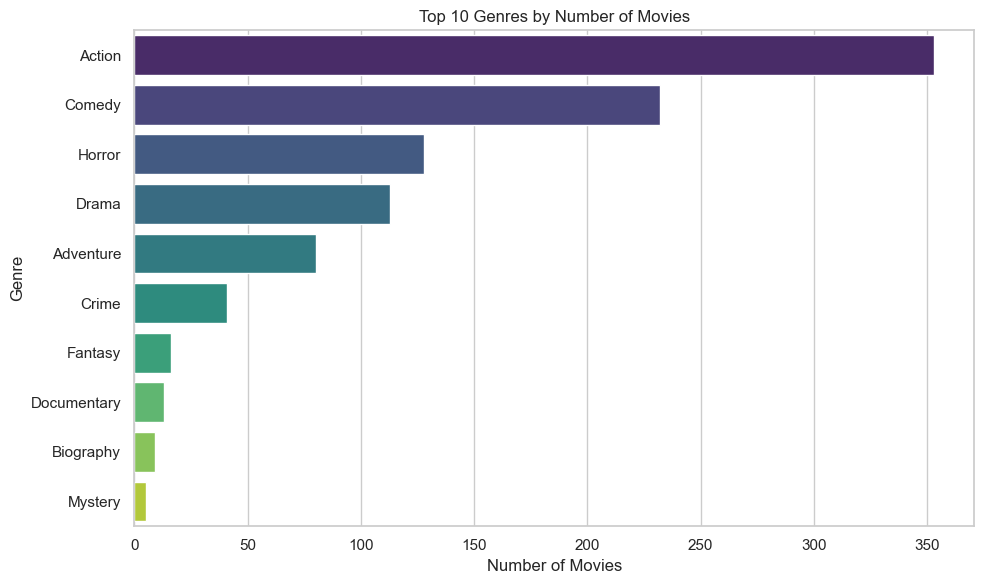

In [18]:
#Top 10 Genres by Number of Movies

query = """
SELECT genres, COUNT(DISTINCT id) AS movie_count
FROM movies
GROUP BY genres
ORDER BY movie_count DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="movie_count", y="genres", data=df, palette="viridis")
plt.title("Top 10 Genres by Number of Movies")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "top_genres_db.png"))
plt.show()


C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\938044064.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\938044064.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_rating", y="genres", data=df, palette="rocket")


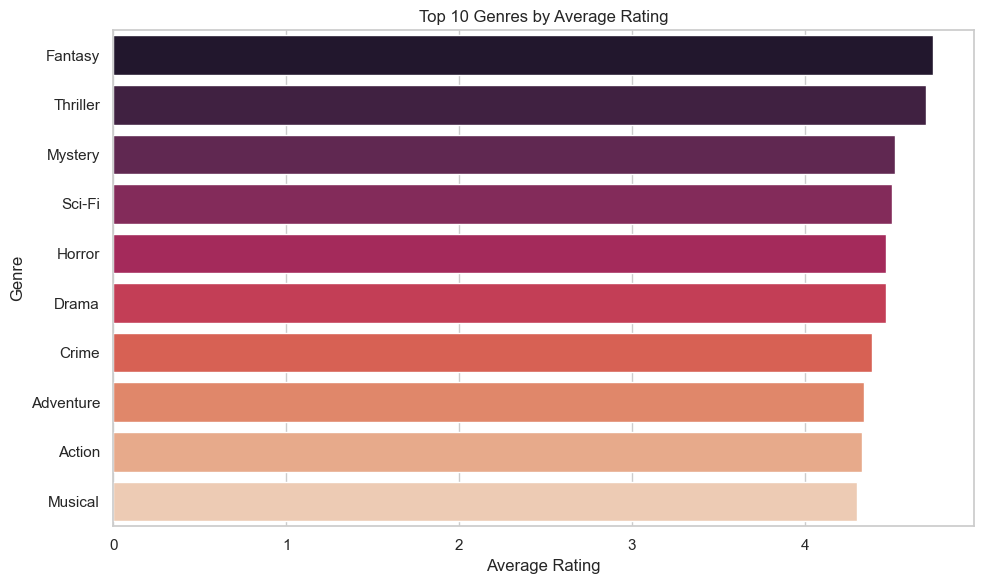

In [24]:
#Top 10 Genres by Average Rating

query = """
SELECT genres, ROUND(AVG(averagerating)::numeric, 2) AS avg_rating
FROM movies
GROUP BY genres
ORDER BY avg_rating DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="avg_rating", y="genres", data=df, palette="rocket")
plt.title("Top 10 Genres by Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "top_rating_genres_db.png"))
plt.show()


C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\4263385843.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\4263385843.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="decade", y="movie_count", data=df, palette="magma")


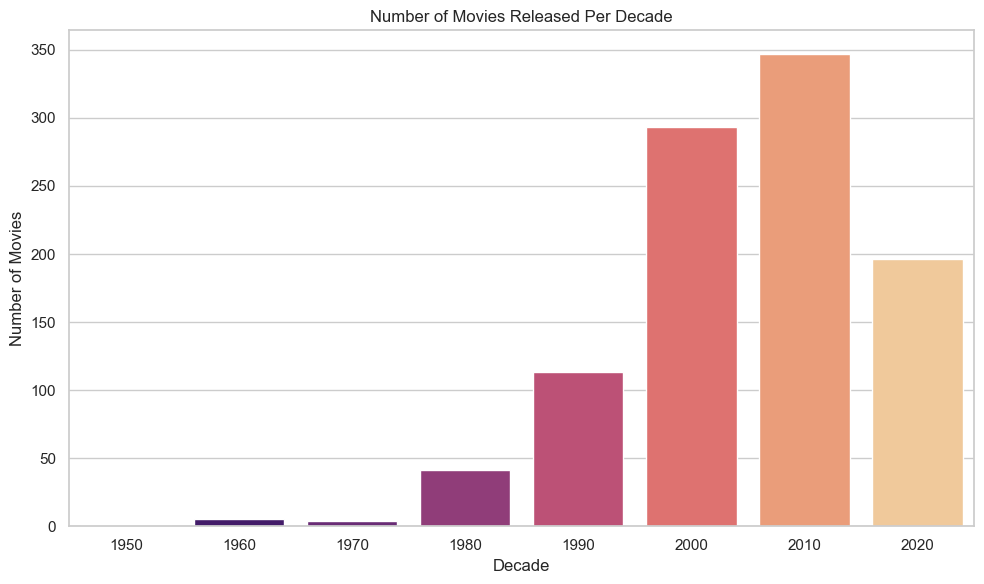

In [25]:
#Movies Released Per Decade
query = """
SELECT decade, COUNT(DISTINCT id) AS movie_count
FROM movies
GROUP BY decade
ORDER BY decade;
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.barplot(x="decade", y="movie_count", data=df, palette="magma")
plt.title("Number of Movies Released Per Decade")
plt.xlabel("Decade")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "movies_per_decade_db.png"))
plt.show()


C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\2365360086.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


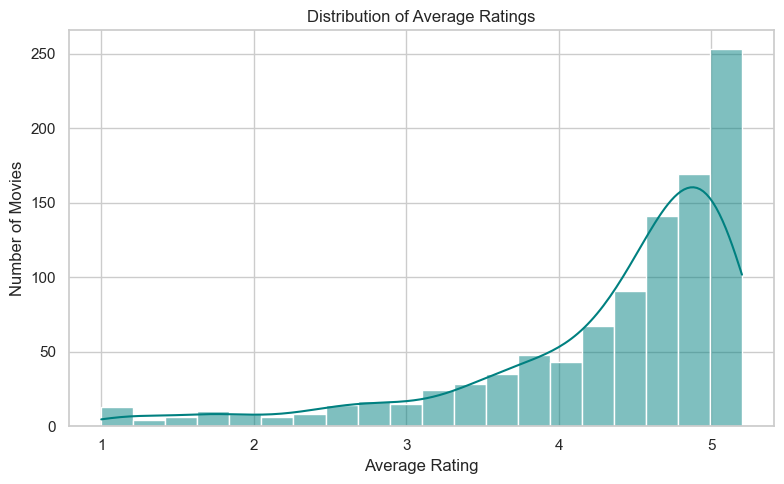

In [26]:
#Rating Distribution
query = "SELECT averagerating FROM movies;"
df = pd.read_sql(query, conn)

plt.figure(figsize=(8,5))
sns.histplot(df['averagerating'], bins=20, kde=True, color="teal")
plt.title("Distribution of Average Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "rating_distribution_db.png"))
plt.show()

C:\Users\Naghma\AppData\Local\Temp\ipykernel_26040\2962400108.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


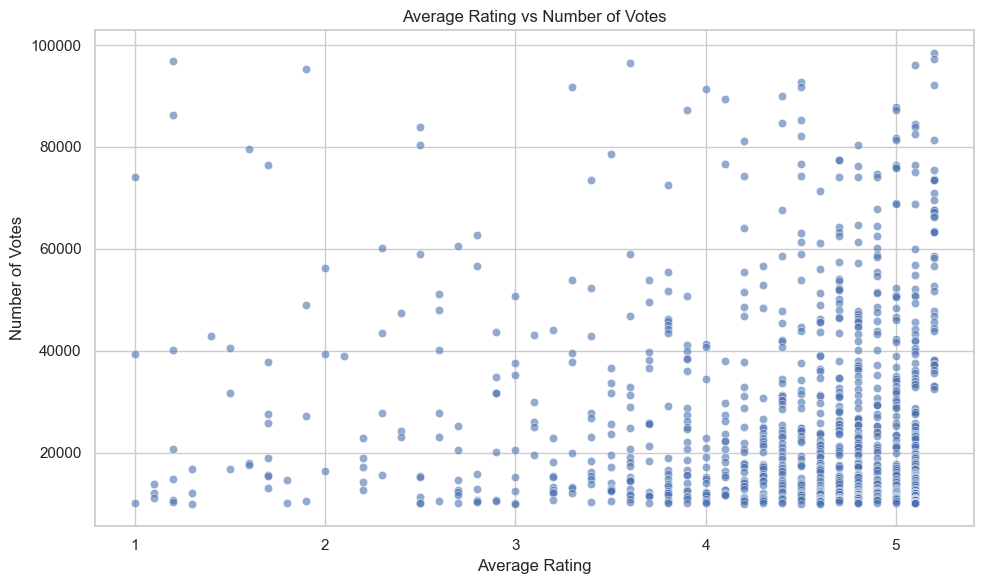

In [27]:
#Average Rating vs Number of Votes
query = """
SELECT averagerating, numvotes
FROM movies
WHERE numvotes < 100000;  -- Optional: remove extreme outliers
"""
df = pd.read_sql(query, conn)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='averagerating', y='numvotes', alpha=0.6)
plt.title("Average Rating vs Number of Votes")
plt.xlabel("Average Rating")
plt.ylabel("Number of Votes")
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "rating_vs_votes_db.png"))
plt.show()

In [28]:
cur.close()
conn.close()